<a href="https://colab.research.google.com/github/zarrinan/DS-Unit-2-Sprint-3-Advanced-Regression/blob/master/module1-logistic-regression/U2_S3_D1_Logistic_Regression_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Logistic Regression Assignment

Logistic regression is the baseline for classification models, as well as a handy way to predict probabilities (since those too live in the unit interval). While relatively simple, it is also the foundation for more sophisticated classification techniques such as neural networks (many of which can effectively be thought of as networks of logistic models).

This is the biggest data you've played with so far, and while it does generally fit in Colab, it can take awhile to run. That's part of the challenge!

Your tasks:

Clean up the variable names in the dataframe
Use logistic regression to fit a model predicting (primary/top) genre
Inspect, iterate, and improve your model
Answer the following questions (written, ~paragraph each):
What are the best predictors of genre?
What information isn't very useful for predicting genre?
What surprised you the most about your results?
Important caveats:

This is going to be difficult data to work with - don't let the perfect be the enemy of the good!
Be creative in cleaning it up - if the best way you know how to do it is download it locally and edit as a spreadsheet, that's OK!
If the data size becomes problematic, consider sampling/subsetting
You do not need perfect or complete results - just something plausible that runs, and that supports the reasoning in your written answers
If you find that fitting a model to classify all genres isn't very good, it's totally OK to limit to the most frequent genres, or perhaps trying to combine or cluster genres as a preprocessing step. Even then, there will be limits to how good a model can be with just this metadata - if you really want to train an effective genre classifier, you'll have to involve the other data (see stretch goals).

This is real data - there is no "one correct answer", so you can take this in a variety of directions. Just make sure to support your findings, and feel free to share them as well! This is meant to be practice for dealing with other "messy" data, a common task in data science.



In [0]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install seaborn==0.9.0 -q

## Assignment - real-world classification

We're going to check out a larger dataset - the [FMA Free Music Archive data](https://github.com/mdeff/fma). It has a selection of CSVs with metadata and calculated audio features that you can load and try to use to classify genre of tracks. To get you started:

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy import optimize
from scipy import stats
from sklearn import linear_model
from sklearn import metrics


In [0]:
sns.__version__

'0.9.0'

In [0]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression


In [0]:
!wget https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
!unzip fma_metadata.zip

In [0]:
tracks = pd.read_csv('fma_metadata/tracks.csv')

In [0]:
# t = pd.read_csv('fma_metadata/tracks.csv', header=[0,1], index_col=0)
#delete repeatitive and non-relevant columns
# tr.drop(columns=[('album', 'engineer'),('album', 'information'), ('album', 'type'),
#                  ('album', 'date_released'),('album', 'date_created'), ('artist', 'latitude'),  
#                  ('artist', 'longitude'),('artist', 'bio'),('artist', 'website'),
#                  ('artist', 'members'), ('artist', 'active_year_end'),('artist','active_year_begin'),
#                  ('artist', 'associated_labels'), ('artist', 'related_projects'), 
#                  ('artist', 'wikipedia_page'),('track', 'license'),  
#                  ('artist', 'date_created'),('track','date_recorded'),('track', 'genres'),
#                  ('track', 'genres_all'), ('track', 'information'), 
#                  ('track', 'publisher'), ('set', 'split'), ('set', 'subset')], inplace=True)
# #get subset of the df where no nan values in the following columns
# tr = tr.dropna(subset=[('track', 'genre_top'), ('artist', 'location'), 
#                        ('album', 'title'),('track', 'title'), 
#                        ('track', 'composer'),('album', 'producer'),
#                        ('track', 'language_code', ('track','lyricist'))])
# #delete row with track_id # 4498 where a lyricist is a NaN
# tr = tr.drop(4498)
#pd.options.mode.use_inf_as_na = True


In [0]:
#rename first column into track_id
tracks.rename(columns={ tracks.columns[0]: "track_id" }, inplace=True)

#set track_id as an index column
tracks.set_index('track_id', inplace=True)

#rename columns by adding relevant information from the first row
for i in range(len(tracks.columns)):
  tracks.rename(columns={tracks.columns[i]: tracks.columns[i] +': ' + tracks.iloc[0, i] }, inplace=True)
  
#Delete first 2 rows
tracks.drop(tracks.index[:2], inplace=True)


In [0]:
tracks.head()

In [164]:
tracks['track.5: duration'] = tracks['track.5: duration'].astype('float64')

print('{} tracks, {} artists, {} albums'.format(
    len(tracks), len(tracks['artist.7: id'].unique()),
    len(tracks['album.5: id'].unique())))
mean_duration = tracks['track.5: duration'].mean()
print('tracks duration: {:.0f} days total, {:.0f} seconds average'.format(
    sum(tracks['track.5: duration']) / 3600 / 24,
    mean_duration))


106574 tracks, 17054 artists, 14928 albums
tracks duration: 343 days total, 278 seconds average


In [165]:
for subset in tracks['set.1: subset'].unique():
    indicator = tracks['set.1: subset'] <= subset
    print('{:6} {:6} tracks  {:.1f} days'.format(
        subset, sum(indicator), sum(indicator) * 30 / 3600 / 24))

small  106574 tracks  37.0 days
medium  98574 tracks  34.2 days
large   81574 tracks  28.3 days


In [0]:
tracks.columns

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


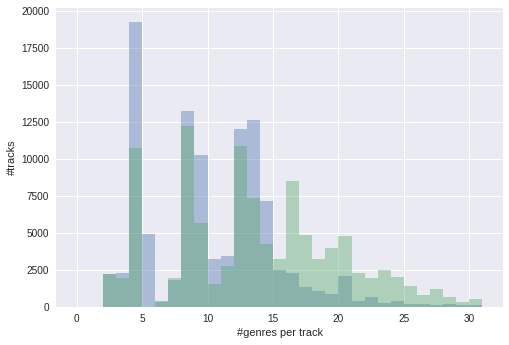

In [166]:
p = sns.distplot(tracks['track.8: genres'].map(len), kde=False, bins=range(32))
p = sns.distplot(tracks['track.9: genres_all'].map(len), kde=False, bins=range(32))
p.set_xlabel('#genres per track')
p.set_ylabel('#tracks');

In [0]:
# delete columns where NaN's more than 2/3 of the data
def delete_nan_columns(df):
  l = df.shape[0]*.6
  for column in df.columns:
    if df[column].isnull().sum() > l:
      df.drop(column, axis=1, inplace=True)
  return df    

delete_nan_columns(tracks)


In [0]:
#delete repeatitive and non-relevant columns
tracks.drop(columns=['artist.8: latitude', 'artist.10: longitude', 'album: comments', 'artist.4: comments',
                    'track.1: comments','artist.3: bio', 'artist.15: website', 'album.6: information', 
                     'artist.11: members', 'album.12: type', 'album.2: date_released',
                     'track.13: license', 'album.1: date_created', 'artist.5: date_created',
                     'track.8: genres','track.9: genres_all'], inplace=True)

In [0]:
#get subset of the df where no nan values in the following columns
tracks = tracks.dropna(subset=['track.7: genre_top', 'artist.9: location', 
                               'album.10: title','track.19: title'])
                              

In [171]:
tracks.isna().sum().sum()

0

In [0]:
#Make a list of date columns
date_columns = ['track.3: date_created']

#convert date columns to datetype columns and trancate them to month
def convert_dates(d):
  for c in date_columns:
    d[c]= d[c].astype(str)
    d[c] = pd.to_datetime(d[c])
    d[c] = d[c].dt.to_period('M')
  return d 

convert_dates(tracks)

In [0]:
# #download df to google drive
# from google.colab import files
# df.to_csv('d.csv', encoding='utf-8', index=False)
# files.download('d.csv')


In [172]:
tracks['set: split'].unique()

array(['training', 'validation', 'test'], dtype=object)

In [0]:
d = tracks.copy()

In [0]:
d['set: split']

In [0]:
def encode_cat(df):
  for col_name in df.columns:
      if(df[col_name].dtype == 'object'):
          df[col_name]= df[col_name].astype('category')
          df[col_name] = df[col_name].cat.codes
  return df         

d = encode_cat(d)

In [0]:
d.astype('float64')

In [0]:
d['set: split']

In [0]:
train_d = d[d['set: split'] == 1]
val_d = d[d['set: split'] == 2]
test_d = d[d['set: split'] == 0]

In [0]:
train_d = train_d.sample(frac=0.1, random_state=42)
val_d = val_d.sample(frac=0.1, random_state=42)
test_d = test_d.sample(frac=0.1, random_state=42)

In [0]:
train_x = train_d.drop('track.7: genre_top', axis=1)
train_y = train_d['track.7: genre_top']

In [0]:
val_x = val_d.drop('track.7: genre_top', axis=1)
val_y = val_d['track.7: genre_top']

In [0]:
# Train multi-classification model with logistic regression
linear_reg = LinearRegression().fit(train_x, train_y)

# Train multinomial logistic regression model
mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg', max_iter=200).fit(train_x, train_y)



In [201]:
print("Multinomial Logistic regression Train Accuracy :", metrics.accuracy_score(train_y, mul_lr.predict(train_x)))
print("Multinomial Logistic regression Validation Accuracy :", metrics.accuracy_score(val_y, mul_lr.predict(val_x)))


Multinomial Logistic regression Train Accuracy : 0.4500582977069569
Multinomial Logistic regression Validation Accuracy : 0.4234527687296417


In [0]:
mul_lr.coef_

## Resources and stretch goals

- Check out the other .csv files from the FMA dataset, and see if you can join them or otherwise fit interesting models with them
- [Logistic regression from scratch in numpy](https://blog.goodaudience.com/logistic-regression-from-scratch-in-numpy-5841c09e425f) - if you want to dig in a bit more to both the code and math (also takes a gradient descent approach, introducing the logistic loss function)
- Create a visualization to show predictions of your model - ideally show a confidence interval based on error!
- Check out and compare classification models from scikit-learn, such as [SVM](https://scikit-learn.org/stable/modules/svm.html#classification), [decision trees](https://scikit-learn.org/stable/modules/tree.html#classification), and [naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html). The underlying math will vary significantly, but the API (how you write the code) and interpretation will actually be fairly similar.
- Sign up for [Kaggle](https://kaggle.com), and find a competition to try logistic regression with
- (Not logistic regression related) If you enjoyed the assignment, you may want to read up on [music informatics](https://en.wikipedia.org/wiki/Music_informatics), which is how those audio features were actually calculated. The FMA includes the actual raw audio, so (while this is more of a longterm project than a stretch goal, and won't fit in Colab) if you'd like you can check those out and see what sort of deeper analysis you can do.